# Classifier probability calibration using Venn-ABERS predictors
**Author: [Carl McBride Ellis](https://www.kaggle.com/carlmcbrideellis)** ([LinkedIn](https://www.linkedin.com/in/carl-mcbride-ellis/))

As beautifully pointed out in the short blog post ["Classification vs. Prediction"](https://www.fharrell.com/post/classification/) by Frank E. Harrell Jr. classification is a *post hoc* decision layer on top of a probabilistic prediction. From this point of view it  is obvious that it is essential that before performing classification one must have the best possible probabilities to work with. Indeed, for cost-sensitive decisions, having good probabilities is imperative. Standard estimator routines such as those in [scikit learn do not necessarily provide this](https://www.diva-portal.org/smash/get/diva2:1603345/FULLTEXT01.pdf) often returning a ranking rather than a probability, and [calibration](https://scikit-learn.org/stable/modules/calibration.html) should be performed. Here we shall calibrate a base estimator using the Venn-ABERS technique and also calculate the results of three [strictly proper scoring rules](https://doi.org/10.1198/016214506000001437), namely the [log loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html), the [Brier score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html).

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 18})
plt.style.use('fivethirtyeight')

import seaborn as sns
sns.set(font_scale=1.5)

import sklearn
sklearn.set_config(transform_output="pandas")

from IPython.display import Markdown

Venn-ABERS predictors perform two [isotonic regressions](https://cseweb.ucsd.edu/~elkan/calibrated.pdf) (using the greatest convex minorant of the cumulative sum diagram), one for for class 0 leading to probabilities $p_0$, and one for class 1 leading to probabilities $p_1$.
$p_0$ and $p_1$ form an interval within which the correct probability is deemed to be located.
A single-valued probability can be obtained by combining these results, for example via

$$    p = \frac{p_1}{1-p_0 + p_1} $$

It is worth mentioning that this technique can also be [extended to multi-class problems](https://proceedings.mlr.press/v60/manokhin17a/manokhin17a.pdf).

We shall make use of the [venn-abers](https://github.com/ip200/venn-abers) package written by Ivan Petej

In [2]:
!pip install -q venn-abers

from venn_abers import VennAbersCalibrator

For our dataset we shall use the [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic-in-all-probability/overview) data

In [3]:
dataset = pd.read_csv("/kaggle/input/spaceship-titanic-in-all-probability/train.csv", index_col="PassengerId")

In [4]:
def cleaning(dataset):
    
    dataset = dataset.drop(["Name","Cabin"], axis=1)
    dataset.CryoSleep = dataset.CryoSleep.replace({True: 1, False: 0})
    dataset.VIP = dataset.VIP.replace({True: 1, False: 0})
    dataset = pd.get_dummies(dataset, drop_first=True, dtype="int")    
    
    return dataset

In [5]:
X = dataset
X = X.drop(["Transported"], axis=1)
X = cleaning(X)
y = dataset["Transported"]

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test,  y_train, y_test   = train_test_split(X, y, test_size=1000, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=1000, random_state=42)

print(X_train.shape)
print(X_calib.shape)
print(X_test.shape)

(6693, 12)
(1000, 12)
(1000, 12)


For our base estimator we shall use the [XGBoost classifier](https://xgboost.readthedocs.io/en/stable/index.html)

In [7]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=1000, random_state=42)

In [8]:
classifier.fit(X_train,y_train)
predictions_base = classifier.predict_proba(X_test)[:,1]

# Inductive (split, or `"prefit"`) Venn-ABERS prediction
IVAP uses a disjoint hold-out calibration dataset (`X_calib`,`y_calib`) extracted from the training data

In [9]:
p_cal  = classifier.predict_proba(X_calib)
p_test = classifier.predict_proba(X_test)

VAC = VennAbersCalibrator()
predictions_IVAP = VAC.predict_proba(p_cal=p_cal, y_cal=y_calib.values, p_test=p_test)[:,1]

# Cross Venn-ABERS prediction
CVAP applies a [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) like splitting to the training data, thus does 
not require the creation of a disjoint hold-out calibration dataset.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42)

In [11]:
VAC = VennAbersCalibrator(estimator=classifier, 
                          inductive=False, 
                          n_splits=5)
VAC.fit(X_train, y_train)
predictions_CVAP = VAC.predict_proba(X_test)[:,1]

# Results
Here are the [calibration curves](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html), also known as reliability diagrams, for our three calculations, along with the corresponding performance metrics results.

##  Predictor: No calibration

####  Brier score 0.1869

####  Log loss 0.73839

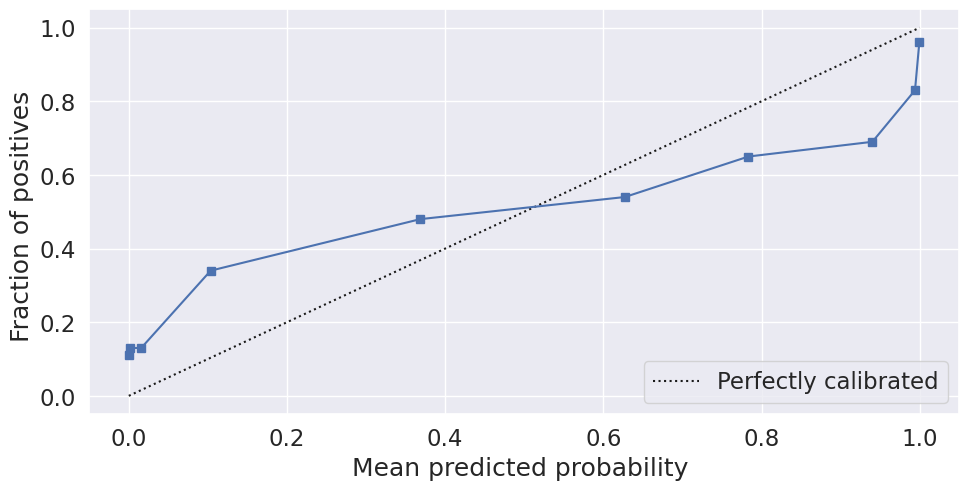

##  Predictor: Inductive Venn-ABERS

####  Brier score 0.16526

####  Log loss 0.49805

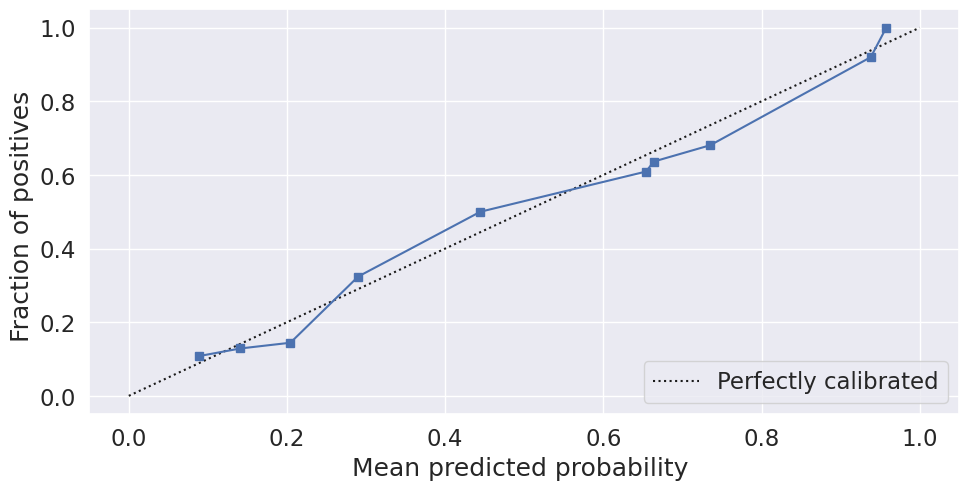

##  Predictor: Cross Venn-ABERS

####  Brier score 0.16973

####  Log loss 0.50891

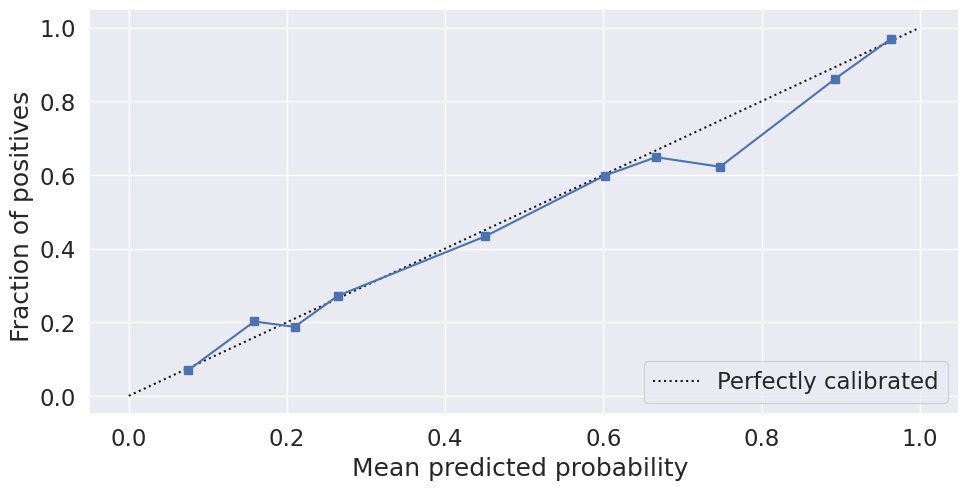

In [12]:
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay

from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss
#from sklearn.metrics import roc_auc_score

predictions = [predictions_base,
               predictions_IVAP,
               predictions_CVAP,
              ]

prediction_names = ["No calibration",
                    "Inductive Venn-ABERS",
                    "Cross Venn-ABERS",
              ]

for name, y_prob in enumerate(predictions):
    display(Markdown('##  Predictor: ' + prediction_names[name] ))
    display(Markdown('####  Brier score ' + round(brier_score_loss(y_test, y_prob),5).astype("str") ))
    display(Markdown('####  Log loss ' + round(log_loss(y_test, y_prob),5).astype("str") ))
    #display(Markdown('####  ROC AUC ' + round(roc_auc_score(y_test, y_prob),5).astype("str") ))

    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='quantile')
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    CalibrationDisplay(prob_true, prob_pred, y_prob).plot(ax=ax1)
    plt.show()

# What do $p_0$ and $p_1$ look like?
To provide the values of $p_0$ and $p_1$ we shall make use of the IVAP code from ["Venn-ABERS Predictor"](https://github.com/ptocca/VennABERS), written by Paolo Toccaceli, and plot the resulting values sorted by $p$. We also plot the difference between $p_1$ and $p_0$, which is an indicator of how much uncertainty there is associated with each individual prediction.

In [13]:
import sys
!git clone https://github.com/ptocca/VennABERS
sys.path.append("VennABERS")
import VennABERS

Cloning into 'VennABERS'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 64 (delta 22), reused 31 (delta 11), pack-reused 12 (from 1)
Unpacking objects: 100% (64/64), 70.64 KiB | 769.00 KiB/s, done.


In [14]:
# calibrPts: a list of pairs (score,label) corresponding to the scores and labels of the calibration examples.
y_pred_calib = classifier.predict_proba(X_calib)[:,1]
calibrPts = zip(list(y_pred_calib),list(y_calib))

# testScores: a list of floats corresponding to the scores for the test objects.
testScores = classifier.predict_proba(X_test)[:,1]

p0,p1 = VennABERS.ScoresToMultiProbs(calibrPts,testScores)

p = p1/(1-p0+p1)

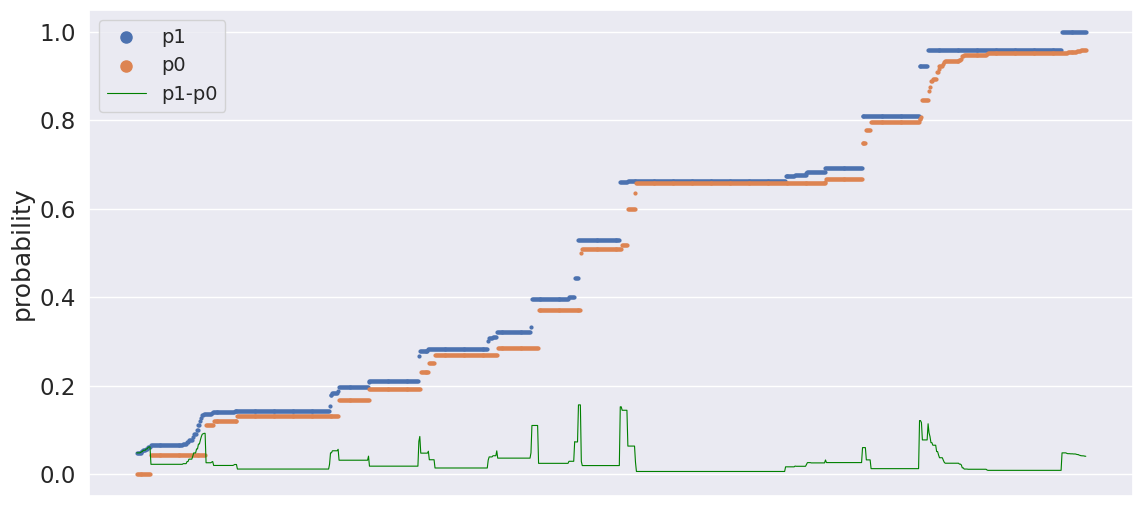

In [15]:
predictions = y_test.to_frame()
predictions.columns = ['y_true']
predictions["p0"] = p0
predictions["p1"] = p1
predictions["p"]  = p
predictions["width"] = predictions["p1"] - predictions["p0"]
predictions = predictions.sort_values(by=['p'])
predictions = predictions.reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(x=predictions.index,y=predictions["p1"],label="p1",s=4)
plt.scatter(x=predictions.index,y=predictions["p0"],label="p0",s=4)
plt.plot(predictions.index,predictions["width"],label="p1-p0",lw=0.8,color="green")
plt.legend(loc="upper left",fontsize=14, scatterpoints=1, markerscale=4)
plt.ylabel("probability")
plt.xticks([])
plt.show()

# Conclusion
Not only can we see that calibration leads to better metric scores, perhaps more importantly we can see from the calibration curves that the probabilities are more reliable. In view of this one should always calibrate ones probabilities before using the probabilities or before proceeding to assign classes to the predictions.
# Related reading
Calibration
* [Bianca Zadrozny, and Charles Elkan "*Obtaining calibrated probability estimates from decision trees and naive Bayesian classifiers*", ICML '01: Proceedings of the Eighteenth International Conference on Machine Learning pp. 609-616 (2001)](https://cseweb.ucsd.edu/~elkan/calibrated.pdf)
* [Alexandru Niculescu-Mizil, and Rich Caruana "*Predicting Good Probabilities With Supervised Learning*", ICML '05: Proceedings of the 22nd international conference on Machine learning pp. 625-632 (2005)](https://doi.org/10.1145/1102351.1102430),  ([pdf](https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf))
* [Chuan Guo, Geoff Pleiss, Yu Sun, Kilian Q. Weinberger "*On Calibration of Modern Neural Networks*", Proceedings of the 34th International Conference on Machine Learning, PMLR **70** pp. 1321-1330 (2017)](https://proceedings.mlr.press/v70/guo17a/guo17a.pdf)
* [Ulf Johansson, and Patrick Gabrielsson "*Are Traditional Neural Networks Well-Calibrated?*", 2019 International Joint Conference on Neural Networks (IJCNN) (2019)](https://doi.org/10.1109/IJCNN.2019.8851962)
* [Dirar Sweidan, and Ulf Johansson "*Probabilistic Prediction in scikit-learn*", The 18th International Conference on Modeling Decisions for Artificial Intelligence (2021)](https://www.diva-portal.org/smash/get/diva2:1603345/FULLTEXT01.pdf)
* [Yu Bai, Song Mei, Huan Wang, Caiming Xiong "*Don’t Just Blame Over-parametrization for Over-confidence: Theoretical Analysis of Calibration in Binary Classification*", Proceedings of the 38th International Conference on Machine Learning, PMLR **139** pp. 566-576 (2021)](https://proceedings.mlr.press/v139/bai21c/bai21c.pdf)
* [Jarosław Błasiok, Parikshit Gopalan, Lunjia Hu, and Preetum Nakkiran "*When Does Optimizing a Proper Loss Yield Calibration?*", NeurIPS (2023)](https://arxiv.org/pdf/2305.18764.pdf)
* [Telmo Silva Filho, Hao Song, Miquel Perello-Nieto, Raul Santos-Rodriguez, Meelis Kull, and Peter Flach "*Classifier calibration: A survey on how to assess and improve predicted class probabilities*", Machine Learning **volume 112**, pp. 3211–3260 (2023)](https://doi.org/10.1007/s10994-023-06336-7)


See also:
* [Probability calibration](https://scikit-learn.org/stable/modules/calibration.html) on scikit-learn

Venn-ABERS
* [Vladimir Vovk, Glenn Shafer, and Ilia Nouretdinov "*Self-calibrating Probability Forecasting*", NIPS'03: Proceedings of the 16th International Conference on Neural Information Processing Systems pp. 1133-1140 (2003)](https://proceedings.neurips.cc/paper_files/paper/2003/file/10c66082c124f8afe3df4886f5e516e0-Paper.pdf)
* [Vladimir Vovk, and Ivan Petej "*Venn-ABERS Predictors*", Proceedings of UAI (2014)](https://arxiv.org/pdf/1211.0025.pdf)
* [Vladimir Vovk, Ivan Petej, and Valentina Fedorova "*Large-scale probabilistic prediction with and without validity guarantees*", Advances in Neural Information Processing Systems **28** (2015)](https://arxiv.org/pdf/1511.00213.pdf)
* [Valery Manokhin "*Multi-class probabilistic classification using inductive and cross Venn–Abers predictors*", Proceedings of the Sixth Workshop on Conformal and Probabilistic Prediction and Applications, PMLR **60** pp. 228-240 (2017)](https://proceedings.mlr.press/v60/manokhin17a/manokhin17a.pdf)
* [Valeriy Manokhin "*Practical Guide to Applied Conformal Prediction*", Packt Publishing (2023)](https://www.packtpub.com/product/practical-guide-to-applied-conformal-prediction/9781805122760) (Chapter 6)

See also:
* ["Conformal_Prediction_PSS3, E2"](https://www.kaggle.com/code/predaddict/conformal-prediction-pss3-e2) kaggle notebook by [predict_addict]()
* ["How to calibrate your classifier in an intelligent way using Venn-Abers Conformal Prediction"](https://valeman.medium.com/how-to-calibrate-your-classifier-in-an-intelligent-way-a996a2faf718) by Valeriy Manokhin

python code
* [venn-abers](https://github.com/ip200/venn-abers) on GitHub by Ivan Petej
* [Venn-ABERS Predictor](https://github.com/ptocca/VennABERS/tree/master) on GitHub, an implementation of IVAP by Paolo Toccaceli